<a href="https://colab.research.google.com/github/zaitsevIV/hse_gp2_scrap-api/blob/main/GP_2_%D0%9A%D0%BE%D0%BC%D0%B0%D0%BD%D0%B4%D0%B0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Современные методы анализа данных и машинного обучения,

БИ, НИУ ВШЭ, 2024-25 учебный год

Групповой проект №2. DE: Scraping & API


Багирова Элина

Берштейн Мария

Иванов Иван

Зайцев Иван

Погосьянц Полина

Кучер Павел

## **Scraping**

In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import time
from tqdm import tqdm


links_basck = []
pages = range(1, 50)
time_start = time.time()
for current_page in tqdm(pages):
  url = f'https://bashkortostan.rabota.ru/vacancy/?page={current_page}'
  page = requests.get(url)
  soup = BeautifulSoup(page.text, 'html')
  for link in soup.find_all('a', class_="vacancy-preview-card__title_border"):
    links_basck.append(f"https://bashkortostan.rabota.ru{link.get('href')}")
    time.sleep(0.5)
  time.sleep(2)
time_end = time.time()
print(f'\nВремя загрузки данных по Республики Башкортостан - {(time_end - time_start) / 60}')

In [ ]:
links_chelyb = []
pages = range(1, 54)
time_start = time.time()
for current_page in tqdm(pages):
  url = f'https://chelyabinskaya.rabota.ru/vacancy/?page={current_page}'
  page = requests.get(url)
  soup = BeautifulSoup(page.text, 'html')
  for link in soup.find_all('a', class_="vacancy-preview-card__title_border"):
    links_chelyb.append(f"https://chelyabinskaya.rabota.ru{link.get('href')}")
    time.sleep(0.5)
  time.sleep(2)
time_end = time.time()
print(f'\nВремя загрузки данных по Челябинской области {(time_end - time_start) / 60}')

In [ ]:
result_basck = []
time_start = time.time()
for i in tqdm(range(len(links_basck))):
  page = requests.get(links_basck[i])
  soup = BeautifulSoup(page.text, 'html')
  try:
    city = soup.find('span', class_='vacancy-requirements__city').get_text().strip()[:-1]
  except AttributeError:
    city = np.nan
  try:
    position = soup.find('h1', class_='vacancy-card__title').get_text().replace("\n", "").strip()
  except AttributeError:
    position = np.nan
  try:
    salary = soup.find('h3', class_='vacancy-card__salary').get_text()
  except AttributeError:
    salary = np.nan
  result_basck.append([city, position, salary, links_basck[i]])
  time.sleep(0.5)
time_end = time.time()

In [ ]:
result_chelyb = []
time_start = time.time()
for i in tqdm(range(len(links_chelyb))):
  page = requests.get(links_chelyb[i])
  soup = BeautifulSoup(page.text, 'html')
  try:
    city = soup.find('span', class_='vacancy-requirements__city').get_text().strip()[:-1]
  except AttributeError:
    city = np.nan
  try:
    position = soup.find('h1', class_='vacancy-card__title').get_text().replace("\n", "").strip()
  except AttributeError:
    position = np.nan
  try:
    salary = soup.find('h3', class_='vacancy-card__salary').get_text()
  except AttributeError:
    salary = np.nan
  result_chelyb.append([city, position, salary, links_chelyb[i]])
  time.sleep(0.5)
time_end = time.time()

In [ ]:
import pandas as pd
chelyb = pd.DataFrame(result_chelyb, columns=['city', 'position', 'salary', 'link'])
basck = pd.DataFrame(result_basck, columns=['city', 'position', 'salary', 'link'])

In [ ]:
basck.to_csv('basck', sep=',', encoding='utf-8')
chelyb.to_csv('chelyb', sep=',', encoding='utf-8')

## **Используем Selenium**

In [ ]:
# Удаляем старые версии Chrome и Chromedriver
!apt-get remove -y chromium-browser chromium-chromedriver
!rm -rf /usr/bin/chromedriver /usr/bin/chromium-browser

In [ ]:
# Устанавливаем зависимости
!apt-get update -y
!apt-get install -y chromium-browser chromium-chromedriver
!pip install selenium webdriver-manager

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
from tqdm import tqdm

In [ ]:
# Опции браузера
options = Options()
#Этот блок кода направлен на то, что мы отключаем те функции хрома, которые могут нам помешать в парсинге
# отключает графику браузера, чтобы она не перезагружала код
options.add_argument("--headless")
# отключаем функции безопасности хрома
options.add_argument("--no-sandbox")
# отключает использование временного хранилища для обмена данными между процессами
options.add_argument("--disable-dev-shm-usage")
#Так как мы работает в headless поэтому нам нужно отключить аппаратное ускорение
options.add_argument("--disable-gpu")
# это отключение расширений хрома
options.add_argument("--disable-extensions")

# Запуск браузера
service = Service()
driver = webdriver.Chrome(service=service, options=options)
wait = WebDriverWait(driver, 10)
# Функция ппарсинга конкретных блоков: вакансии, зарплата,город.
def parse_vacancy_page():
    time.sleep(2)
    try:
        city = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'vacancy-requirements__city'))).text.strip()
    except Exception:
        city = None

    try:
        position = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'vacancy-card__title'))).text.strip()
    except Exception:
        position = None

    try:
        salary = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'vacancy-card__salary'))).text.strip()
    except Exception:
        salary = None
# Возвращает список с информацией о вакансии и её URL
    return [city, position, salary, driver.current_url]
# собираем вакансии со всех страниц (взяла для примера 10)
def scrape_vacancies(base_url, max_pages=10, search_query=None):
    all_vacancies = []

    for current_page in tqdm(range(1, max_pages + 1)):
        url = f'{base_url}?page={current_page}'
        driver.get(url)
#ждем поле поиска, вводим запрос, нажимаем энтер(имитация действий человека), ждем 3 сек загрузки результатов
        if search_query:
            try:
                search_box = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'search-input')))
                search_box.clear()
                search_box.send_keys(search_query)
                search_box.send_keys(Keys.RETURN)
                time.sleep(3)
            except Exception:
                pass
#прокручиваем вниз до конца странички
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        try:
            job_links = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'vacancy-preview-card__title_border'))) #ищем ссылку на вакансию
            for job in job_links:
                try:
                    job_url = job.get_attribute("href")  # Получаем ссылку
                    driver.get(job_url)  # Открываем в той же вкладке
                    time.sleep(2)
                    all_vacancies.append(parse_vacancy_page())
                    driver.get(url)  # Возвращаемся на список вакансий
                    time.sleep(2)
                except Exception:
                    continue
        except Exception:
            continue

    return all_vacancies

# Запуск парсинга
basck_data = scrape_vacancies('https://bashkortostan.rabota.ru/vacancy', max_pages=20, search_query="Продавец-консультант")
chelyb_data = scrape_vacancies('https://chelyabinskaya.rabota.ru/vacancy', max_pages=20, search_query="Менеджер по продажам")

# Сохранение данных
basck_df = pd.DataFrame(basck_data, columns=['city', 'position', 'salary', 'link'])
chelyb_df = pd.DataFrame(chelyb_data, columns=['city', 'position', 'salary', 'link'])

basck_df.to_csv('basck_vacancies.csv', sep=',', encoding='utf-8', index=False)
chelyb_df.to_csv('chelyb_vacancies.csv', sep=',', encoding='utf-8', index=False)

# Закрываем браузер
driver.quit()

Обе функции используются для парсинга вакансий, но у них разные задачи:

scrape_vacancies(base_url, max_pages=10, search_query=None)
Главная функция, которая собирает вакансии со всех страниц.
Открывает страницы с вакансиями (base_url?page=номер_страницы).
Вводит поисковый запрос, если он указан.
Находит ссылки на вакансии и переходит по ним.
Для каждой вакансии вызывает parse_vacancy_page().
Возвращается на страницу списка и продолжает парсинг.

parse_vacancy_page()
Эта функция вызывается внутри scrape_vacancies.
Она извлекает информацию о вакансии (город, название, зарплату, ссылку).
Работает только на странице конкретной вакансии.

Тем самым:
1. scrape_vacancies обходит все страницы и вакансии.
2. parse_vacancy_page парсит конкретную вакансию.

## **API**

In [ ]:
import requests
import pandas as pd
url = "https://api.hh.ru/areas"
response = requests.get(url)
data = response.json()
cities_list = []
for country in data:
    for region in country.get("areas", []):
        for city in region.get("areas", []):
            cities_list.append(
                {
                    "ID": city["id"],
                    "Город": city["name"],
                    "Регион": region["name"],
                    "Страна": country["name"]})
c = pd.DataFrame(cities_list)
c["ID"] = pd.to_numeric(c["ID"]).astype(int)
c_bash = c[(c['Регион'] == 'Республика Башкортостан') & (c['Город'] != 'Уфа')]
c_bash

In [ ]:
c_bash_d = dict(zip(c_bash["ID"], c_bash["Город"]))
c_bash_d

In [ ]:
import time
cities = c_bash_d
url = "https://api.hh.ru/vacancies"
all_vacancies = []
for city_id, city_name in cities.items():
  page = 0
  while page < 20:
      params = {
            'per_page': 100,
            'page': page,
            'area': city_id
        }
      response = requests.get(url, params=params)
      data = response.json()
      if not data.get('items'):
          break
      all_vacancies.extend(data['items'])
      if len(data['items']) < 100:
          break
      time.sleep(1)
      page += 1
pd.DataFrame(all_vacancies)

In [ ]:
pd.DataFrame(all_vacancies).to_csv('башкирия_апи.csv')

In [ ]:
import requests
url = "https://api.hh.ru/vacancies"
response = requests.get(url)
pd.DataFrame(response.json()['items']).head(1)

In [ ]:
url2 = "https://api.hh.ru/salary_statistics/dictionaries/salary_areas"
response2 = requests.get(url2)
pd.DataFrame(response2.json()).head(3)

In [ ]:
url3 = "https://api.hh.ru/salary_statistics/dictionaries/employee_levels"
response3 = requests.get(url3)
pd.DataFrame(response3.json()).head(3)

In [ ]:
url4 = "https://api.hh.ru/salary_statistics/dictionaries/professional_areas"
response4 = requests.get(url4)
pd.DataFrame(response4.json()).head(4)

In [ ]:
url5 = "https://api.hh.ru/salary_statistics/dictionaries/salary_industries"
response5 = requests.get(url5)
pd.DataFrame(response5.json()).head(3)

# **Бизнес задачи**

**1) Посмотреть распределение вакансий и проанализировать заработные платы по Уфе и остальной части Башкирии**

**2) Посмотреть распределение вакансий и проанализировать заработные платы по Челябинской области**

**3) Сделать сравнение результатов Башкирии и Челябинска**

# **Первичное знакомство с данными**
**1) basck - вакансии по Республике Башкортостан, полученные с помощью скрэйпинга**

**2) chelyb - вакансии по Челябинской области, полученные с помощью скрэйпинга**

**3) bash - вакансии по городам Республики Башкортостан кроме Уфы, полученные с помощью API**

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
basck = pd.read_excel('/content/basck.xlsx')


**Общая документация по столбцам из basck**

1) city - город, откуда нужно будет работать (если город не находится в Челябинской области, то это означает, что работа удаленная)

2) salary - З/П в разных форматах, об этом ниже

3) position - название вакансии

In [ ]:
chelyb = pd.read_excel('/content/chelyb.xlsx')


**Общая документация по столбцам из chelyb**

1) city - город, откуда нужно будет работать (если город не находится в Челябинской области, то это означает, что работа удаленная)

2) salary - З/П в разных форматах, об этом ниже

3) position - название вакансии


In [ ]:
bash = pd.read_csv('башкирия_апи.csv')


**Общая документация по столбцам из basck**

id — идентификатор вакансии.

name — название вакансии.

department — название отдела( оч много пропусков )

area — информация о регионе ( внутри лежат бесполезные данные, которые нужно удалить )

published_at, created_at — дата публикации и создания вакансии.

archived — архивирована ли вакансия (True/False).

premium — премиум-объявление (True/False).

Зарплата:

salary — зарплата в виде словаря ({"from": X, "to": Y, "currency": "RUR"}), требует разбиения на отдельные столбцы.

Дополнительные параметры:

type — тип вакансии (например, рекламная).

address — адрес (много пропусков).

employment, employment_form — форма занятости ({"id": "full", "name": "Полная занятость"}).

experience — требуемый опыт работы.

schedule, working_days, working_time_intervals, working_time_modes — график работы.
internship — является ли стажировкой (True/False).

accept_temporary, accept_incomplete_resumes — принимает ли временных сотрудников и неполные резюме.

Контакты и ссылки:

url, alternate_url, apply_alternate_url — ссылки на вакансию.

contacts — информация о контактах (полностью пуст).

response_url, immediate_redirect_url — URL для отклика (много пропусков).

Рекламные параметры:

is_adv_vacancy, adv_context, adv_response_url — рекламные атрибуты (почти все пустые).

branding — бренд компании (много пропусков).

video_vacancy — есть ли видео в вакансии.


# **ЭТАП 1** - **удаление ненужных и создание новых столбцов, работа над форматом данных**

**Преобразование столбцов в пригодный для анализа формат**

In [ ]:
bash['salary_from'] = bash['salary'].apply(lambda x: eval(x)['from'] if pd.notna(x) else None)
bash['salary_to'] = bash['salary'].apply(lambda x: eval(x)['to'] if pd.notna(x) else None)
bash['type'] = bash['type'].apply(lambda x: eval(x)['name'] if pd.notna(x) else None)
bash['area_name'] = bash['area'].apply(lambda x: eval(x)['name'] if pd.notna(x) else None)
bash['working_hours'] = bash['working_hours'].apply(lambda x: eval(x)[0]['id'] if pd.notna(x) and isinstance(eval(x), list) and len(eval(x)) > 0 else None)
bash['working_hours'] = bash['working_hours'].str.extract('(\d+)')
bash['area_url'] = bash['area'].apply(lambda x: eval(x)['url'] if pd.notna(x) else None)
bash['department'] = bash['department'].apply(lambda x: eval(x)['name'] if pd.notna(x) else None)
bash['experience'] = bash['experience'].apply(lambda x: eval(x)['name'] if pd.notna(x) else None)
bash['employment'] = bash['employment'].apply(lambda x: eval(x)['name'] if pd.notna(x) else None)
bash['professional_roles'] = bash['professional_roles'].apply(lambda x: eval(x)[0]['name'] if pd.notna(x) and isinstance(eval(x), list) and len(eval(x)) > 0 else None)
bash['work_schedule_by_days'] = bash['work_schedule_by_days'].apply(lambda x: eval(x)[0]['name'] if pd.notna(x) and isinstance(eval(x), list) and len(eval(x)) > 0 else None)

**Первичное удаление столбцов, где все значения Nan**

In [ ]:
bash = bash.dropna(axis=1, how='all')

**Преобразование значений столбца "salary" в единый формат**

1) в случае диапазона З/П в виде "число - число" была произведена замена на среднее значение между двумя крайними границами

2) в случае значений "по договоренности" была произведена замена на Nan, так как определить зарплату по другим критериям было невозможно

3) в случае значений "до число" была произведена замена на 0.8 * число так как в среднем зарплаты в случае указании такого значения З/П
зарплата получается на 20% ниже порога

4) в случае значений "от число" была произведена замена на 1.2 * число, так как в среднем зарплаты  в случае указании такого значения З/П зарплата получается на 20% выше порога



In [ ]:
basck["salary"] = basck["salary"].astype(str).str.strip().str.lower()
basck["salary"] = basck["salary"].str.replace(r'\s+', '', regex=True)
basck["salary"] = basck["salary"].str.replace(r'руб\.?', '', regex=True)
basck.loc[basck["salary"].str.contains("подоговоренности", na=False), "salary"] = " "
mask_range = basck["salary"].str.contains(",", na=False)
basck.loc[mask_range, "salary"] = basck.loc[mask_range, "salary"].str.split(",").apply(lambda x: (float(x[0]) + float(x[1])) / 2 if len(x) == 2 else np.nan)
mask_max = basck["salary"].str.startswith("до", na=False)
basck.loc[mask_max, "salary"] = basck.loc[mask_max, "salary"].str[2:].astype(float) * 0.8
mask_min = basck["salary"].str.startswith("от", na=False)
basck.loc[mask_min, "salary"] = basck.loc[mask_min, "salary"].str[2:].astype(float) * 1.2
basck["salary"] = pd.to_numeric(basck["salary"], errors='coerce')
basck = basck[["city","position","salary"]]
basck


,city,position,salary
0,Уфа,Менеджер по продажам (автомобилестроение),100000.00
1,NaN,NaN,NaN
2,Уфа,Формовщик,57500.00
3,Уфа,Жиловщик,53050.00
4,Уфа,Мойщик тары,32500.00
...,...,...,...
1454,Москва,Охранник 6 разряда (вахта),145000.00
1455,Москва,Дежурный/консьерж,90000.00
1456,Москва,Дежурный/охранник на КПП,58500.00
1457,Зеленоград,Охранник-контролер,68500.00


**Преобразование значений столбца "salary" в единый формат**

1) в случае диапазона З/П в виде "число - число" была произведена на среднее значение между двумя крайними границами

2) в случае значений "по договоренности" была произведена замена на Nan, так как определить зарплату по другим критериям было невозможно

3) в случае значений "до число" была произведена замена на 0.8 * число так как в среднем зарплаты в случае указании такого значения З/П
зарплата получается на 20% ниже порога

4) в случае значений "от число" была произведена замена на 1.2 * число, так как в среднем зарплаты  в случае указании такого значения З/П зарплата получается на 20% выше порога


In [ ]:
chelyb["salary"] = chelyb["salary"].astype(str).str.strip().str.lower()
chelyb["salary"] = chelyb["salary"].str.replace(r'\s+', '', regex=True)
chelyb["salary"] = chelyb["salary"].str.replace(r'руб\.?', '', regex=True)
chelyb.loc[chelyb["salary"].str.contains("подоговоренности", na=False), "salary"] = " "
mask_range = chelyb["salary"].str.contains(",", na=False)
chelyb.loc[mask_range, "salary"] = chelyb.loc[mask_range, "salary"].str.split(",").apply(lambda x: (float(x[0]) + float(x[1])) / 2 if len(x) == 2 else np.nan)
mask_max = chelyb["salary"].str.startswith("до", na=False)
chelyb.loc[mask_max, "salary"] = chelyb.loc[mask_max, "salary"].str[2:].astype(float) * 0.8
mask_min = chelyb["salary"].str.startswith("от", na=False)
chelyb.loc[mask_min, "salary"] = chelyb.loc[mask_min, "salary"].str[2:].astype(float) * 1.2
chelyb["salary"] = pd.to_numeric(chelyb["salary"], errors='coerce')
chelyb= chelyb[["city","position","salary"]]
chelyb

,city,position,salary
0,Челябинск,Продавец непродовольственных товаров,25000.00
1,Казань,Администратор-консультант чата поддержки (удал...,52000.00
2,Нижний Новгород,Консультант входящих сообщений (подработка),65000.00
3,Челябинск,Монтер пути,108000.00
4,Краснодар,Оператор колл-центра (удаленно),47500.00
...,...,...,...
1580,Москва,Охранник 6 разряда (вахта),145000.00
1581,Москва,Дежурный/консьерж,90000.00
1582,Москва,Дежурный/охранник на КПП,58500.00
1583,Зеленоград,Охранник-контролер,68500.00


**Преобразование файла в csv для обработки данных в Excel**

Было удалено большое количество столбцов, остались столбцы:

1) work_schedule_by_days

2) professional_roles(так как name - это более детальное название вакансии)

3) experience

4) employment

5) salary_from

6) salary_to

7) area_name(местоположение работы)

In [ ]:
bash.to_csv('ghgh.csv')

**Открытие преобразованного файла**

In [ ]:
bash = pd.read_excel('/content/bash_itog.xlsx')

**Преобразование значений столбца "salary" в единый формат**

1) в случае, где в столбце salary_from было значение, а в столбце salary_to был пропуск, была произвдена замена пропуска на 1.4*salary_from

**(1.4*число + число) / 2 = 1.2 * число** - это соответствует случаю "от число" в других датафреймах


2) в случае, где в столбце salary_to было значение, а в столбце salary_from был пропуск, была произвдена замена пропуска на 0.6*salary_from

**(0.6*число + число) / 2 = 0.8 * число** - это соответствует случаю "до число" в других датафреймах

3) в остальных случаях все осталось без изменений

такие замены были сделаны для того, чтобы при усреднении salary_to и salary_from получились значения, аналогичные по формату как в двух других датафреймах:

"до число" = 0.8 * число

"от число" = 1.2 *  число

"число - число" = среднее между числами


In [ ]:
bash["salary_to"] = bash.apply(lambda row: 0.6 * row["salary_from"] if pd.isna(row["salary_to"]) and not pd.isna(row["salary_from"]) else row["salary_to"], axis=1)
bash["salary_from"] = bash.apply(lambda row: 1.4 * row["salary_to"] if pd.isna(row["salary_from"]) and not pd.isna(row["salary_to"]) else row["salary_from"], axis=1)
bash['area_name'] = (bash['area_name'].astype(str).fillna('').str.replace(r'\s*\(.*\)', '', regex=True).str.strip())
bash

,work_schedule_by_days,professional_roles,experience,employment,salary_from,salary_to,area_name
0,5/2,Электромонтажник,Нет опыта,Полная занятость,65000.00,85000.00,Абзаново
1,5/2,"Оператор call-центра, специалист контактного ц...",От 1 года до 3 лет,Полная занятость,NaN,NaN,Абзаново
2,5/2,Электромонтажник,Нет опыта,Полная занятость,65000.00,85000.00,Аблаево
3,5/2,"Оператор call-центра, специалист контактного ц...",От 1 года до 3 лет,Полная занятость,NaN,NaN,Аблаево
4,5/2,Электромонтажник,Нет опыта,Полная занятость,65000.00,85000.00,Авдон
...,...,...,...,...,...,...,...
7551,5/2,"Директор магазина, директор сети магазинов",От 1 года до 3 лет,Полная занятость,52600.00,63200.00,Ярославка
7552,2/2,"Продавец-консультант, продавец-кассир",Нет опыта,Полная занятость,30100.00,36200.00,Ярославка
7553,2/2,Товаровед,От 1 года до 3 лет,Полная занятость,35100.00,42200.00,Ярославка
7554,5/2,Электромонтажник,Нет опыта,Полная занятость,65000.00,85000.00,Ярославка


# **ЭТАП 2 - работа с пропусками и дубликатами**

**Удаляем строчки польностью с Nan**

In [ ]:
bash = bash.dropna(axis=0, how='all')
chelyb = chelyb.dropna(axis=0, how='all')
basck = basck.dropna(axis=0, how='all')

**Обработка пропусков у датафрейма bash**

1) Все пропуски заменены на "неизвестно" в столбце график работы

2) Пропуски в столбце з/п были заменены на -1, чтобы в столбце сохранился числовой формат и число было таким, чтобы было понятно, что оно не является истинным значением з/п, так как отрицательной з/п быть не может.

В дальнейшем анализе строчки с такими з / п будут учитываться только при анализе не связанном с з / п, а анализ по з/п будет проводится исключая "-1"

In [ ]:
bash["salary_from"].fillna(-1,inplace=True)
bash["salary_to"].fillna(-1,inplace=True)
bash["work_schedule_by_days"].fillna("неизвестно",inplace=True)

<ipython-input-931-f1ddd0cb6a9b>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bash["salary_from"].fillna(-1,inplace=True)
<ipython-input-931-f1ddd0cb6a9b>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

**Обработка пропусков у датафрейма chelyb**

1) Все пропуски заменены на "неизвестно" в столбце city

2) Пропуски в столбце salary были заменены на -1, чтобы в столбце сохранился числовой формат и число было таким, чтобы было понятно, что оно не является истинным значением з/п, так как отрицательной з/п быть не может.

В дальнейшем анализе строчки с такими з / п будут учитываться только при анализе не связанном с з / п, а анализ по з/п будет проводится исключая "-1"

basck, bash, chelyb

In [ ]:
chelyb["city"].fillna("неизвестно",inplace=True)
chelyb["salary"].fillna(-1,inplace=True)

<ipython-input-932-f01b42d4033e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chelyb["city"].fillna("неизвестно",inplace=True)
<ipython-input-932-f01b42d4033e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chelyb["city"].fillna("неизвестно",inplace=True)
<ipython-input-932-f01b42d4033e>:2: FutureWarning: A value is trying to be set on a

**Обработка пропусков у датафрейма basck**

1) Все пропуски заменены на "неизвестно" в столбце city

2) Пропуски в столбце salary были заменены на -1, чтобы в столбце сохранился числовой формат и число было таким, чтобы было понятно, что оно не является истинным значением з/п, так как отрицательной з/п быть не может.

В дальнейшем анализе строчки с такими з / п будут учитываться только при анализе не связанном с з / п, а анализ по з/п будет проводится исключая "-1"

In [ ]:
basck["city"].fillna("неизвестно",inplace=True)
basck["salary"].fillna(-1,inplace=True)

<ipython-input-954-71625a372b97>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  basck["city"].fillna("неизвестно",inplace=True)
<ipython-input-954-71625a372b97>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

**Удаление полных дубликатов**

In [ ]:
basck = basck.drop_duplicates()
chelyb = chelyb.drop_duplicates()
bash = bash.drop_duplicates()

In [ ]:
bash['salary'] = ((bash['salary_to']+bash['salary_from'])//2)

# **ЭТАП 3 - Формирование первичных гипотез и выявление тенденций**

In [ ]:
basck_ufa_only = basck[basck["city"]=="Уфа"]
basck_ufa_only["position"].value_counts()[:3]

,count
position,
Менеджер по продажам,18
Продавец-консультант,14
Курьер,10


**Три самые популярные очные работы в Уфе**

1) менеджер по продажам

2) продавец-консультант

3) курьер


In [ ]:
basck_ufa_only = basck_ufa_only[basck_ufa_only["salary"]!=-1]
basck_ufa_only['salary'].describe()

,salary
count,440.00
mean,70355.73
std,39840.90
min,13500.00
25%,42500.00
50%,60000.00
75%,85000.00
max,305000.00


**Первичные выводы по зарплате в Уфе**

1) Самая высокая З/П по Уфе - 305000, все остальные зарплаты оказались ниже 300000

2) Средняя зарплата по предложенным вакансиям - 70355, что ниже реальной средней заработной плате по Уфе(84000)




In [ ]:
chelyb["position"].value_counts()[:3]

,count
position,
Менеджер по продажам,87
Менеджер по работе с клиентами,30
Продавец-консультант,24


**Три самых популярных очных работ в Челябинске**

1) менеджер по продажам

2) Менеджер по работе с клиентами

3) продавец-консультант


In [ ]:
chelyb = chelyb[chelyb['salary'] != -1]
chelyb['salary'].describe()

,salary
count,1328.00
mean,75260.71
std,53483.71
min,7200.00
25%,40000.00
50%,60000.00
75%,95000.00
max,650000.00


**Первичные выводы по зарплате по Челябинску**

1) Самая высокая З/П по Челябинской области - 650000

2) Средняя зарплата по предложенным вакансиям - 75260, что ниже реальной средней заработной плате по Челябинской области(97000)


In [ ]:
bash = bash[bash['professional_roles']!='Другое']
bash["professional_roles"].value_counts()

,count
professional_roles,
"Продавец-консультант, продавец-кассир",613
"Оператор call-центра, специалист контактного центра",502
Электромонтажник,479
Водитель,290
"Менеджер по продажам, менеджер по работе с клиентами",285
...,...
Финансовый директор (CFO),1
"Дизайнер, художник",1
"Журналист, корреспондент",1


**Три самых популярных очных работ в Башкирии кроме Уфы**

1) Продавец-консультант, продавец-кассир

2) Оператор call-центра, специалист контактного центра

3) Электромонтажник


In [ ]:
pd.options.display.float_format = '{:.2f}'.format
bash["salary"].astype(int)
bash = bash[(bash["salary"]!=-1)&(bash["salary"]<450000)&(bash["salary"]>3000)]
bash.describe()

,salary_from,salary_to,salary
count,5010.00,5010.00,5010.00
mean,72558.11,70175.50,71366.80
std,52054.46,53918.17,49631.99
min,75.00,2790.00,3360.00
25%,39025.00,33225.00,37500.00
50%,55000.00,50000.00,52775.00
75%,80900.00,85000.00,83800.00
max,470997.80,500000.00,403712.00


**Первичные выводы по зарплате по Башкирии без Уфы**

1) Самая высокая З/П - 403712

2) Средняя зарплата по предложенным вакансиям - 71336, что выше реальной средней заработной плате по Башкирии(65000)


In [ ]:
bash.groupby("area_name").agg({'salary':'mean'}).reset_index().sort_values(ascending=False,by="salary")[:1]

,area_name,salary
8,Аксеново,171333.33


**Город/село с самой высокой средней зарплатой - Аксеново (З/П = 171333)**

In [ ]:
bash.groupby('experience').agg({'salary':'mean'}).reset_index().sort_values(ascending=False,by="salary")

,experience,salary
3,От 3 до 6 лет,111277.47
0,Более 6 лет,93754.55
2,От 1 года до 3 лет,83913.92
1,Нет опыта,56380.68


In [ ]:
bash.groupby('experience').agg({'salary':'median'}).reset_index().sort_values(ascending=False,by="salary")

,experience,salary
3,От 3 до 6 лет,96000.00
0,Более 6 лет,86175.00
2,От 1 года до 3 лет,63595.00
1,Нет опыта,44000.00


**1) Средняя зарплата при условии опыта от 3 до 6 лет больше чем зарплата при условии опыта более 6 лет**

**2) Медианы чуть более сглажены, но разница все равно существенная**

In [ ]:
bash['experience'].value_counts()

,count
experience,
Нет опыта,2607
От 1 года до 3 лет,2063
От 3 до 6 лет,318
Более 6 лет,22


**Вакансий с условием опыта более 6 лет очень мало, поэтому такие результаты, как были выявлены выше, могли получиться такими из-за этого**

# **ЭТАП 4 - Визуализации**

**Boxplot для визуализации распределения зарплат каждого датасета**

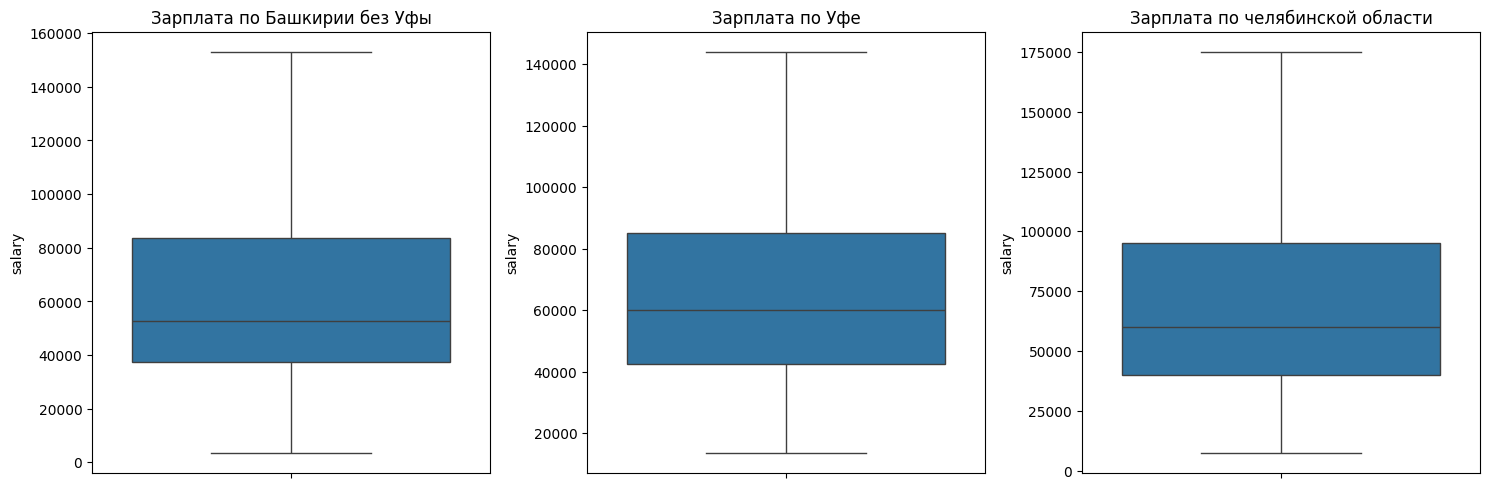

In [ ]:
bash = bash[bash['salary'] != -1]
chelyb = chelyb[chelyb['salary']!=-1]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(y=bash['salary'], showfliers=False)
plt.title('Зарплата по Башкирии без Уфы')
plt.subplot(1, 3, 2)
sns.boxplot(y=basck_ufa_only['salary'], showfliers=False)
plt.title('Зарплата по Уфе')
plt.subplot(1, 3, 3)
sns.boxplot(y=chelyb['salary'], showfliers=False)
plt.title('Зарплата по челябинской области')
plt.tight_layout()
plt.show()


**Видно, что распределение зарплат похоже на друг друга, из различий видно, что закрашенная часть графика по Челябинской области находится чуть выше остальных, что указывает на более высокую среднюю З/П в Челябинской области относительно Башкирии**

**Создание двух новых столбцов**

**1) Группы доходов. Источник: https://t-j.ru/middle-class/**

Были добавлены группы по среднедушевых доходам Россиян, указанным на этом сайте - **salary_range**

**2) Процент относительно всех групп**

Был добавлен процент Россиян, находящихся в этой группе, с этого же сайта - **salary_percentage_rf**



In [ ]:
def categorize_salary(salary):
    if salary <= 7000:
        return 'До 7000', 1.7
    elif salary <= 10000:
        return '7000 - 10000', 3.3
    elif salary <= 14000:
        return '10000 - 14000', 6.7
    elif salary <= 19000:
        return '14000 - 19000', 10.0
    elif salary <= 27000:
        return '19000 - 27000', 16.0
    elif salary <= 45000:
        return '27000 - 45000', 26.7
    elif salary <= 60000:
        return '45000 - 60000', 13.0
    elif salary <= 75000:
        return '60000 - 75000', 7.9
    elif salary <= 100000:
        return '75000 - 100000', 7.1
    else:
        return 'Свыше 100000', 7.6
bash[['salary_range', 'salary_percentage_rf']] = bash['salary'].apply(lambda x: pd.Series(categorize_salary(x)))
basck_ufa_only[['salary_range', 'salary_percentage_rf']] = basck['salary'].apply(lambda x: pd.Series(categorize_salary(x)))
chelyb[['salary_range', 'salary_percentage_rf']] = chelyb['salary'].apply(lambda x: pd.Series(categorize_salary(x)))



**Был добавлен столбец процента вакансий по Башкирии кроме Уфы (по предложенной зарплате), которые попадают в группы среднедушевого дохода Россиян - percentage_bash**

In [ ]:
bash_g = bash.groupby(['salary_range', 'salary_percentage_rf']).agg({'salary':'count'}).reset_index()
bash_g["percentage_bash"] = (bash_g['salary'] / len(bash))*100
bash_g = bash_g[["salary_range","salary_percentage_rf","percentage_bash"]]
bash_g

,salary_range,salary_percentage_rf,percentage_bash
0,10000 - 14000,6.70,0.12
1,14000 - 19000,10.00,0.40
2,19000 - 27000,16.00,4.15
3,27000 - 45000,26.70,36.03
4,45000 - 60000,13.00,17.01
5,60000 - 75000,7.90,13.75
6,7000 - 10000,3.30,0.04
7,75000 - 100000,7.10,8.38
8,До 7000,1.70,0.08
9,Свыше 100000,7.60,20.04


**Был построен график сравнения процентов людей по России, входящих в группы по доходу и средней зарплаты по вакансиям в Башкортостане без Уфы**

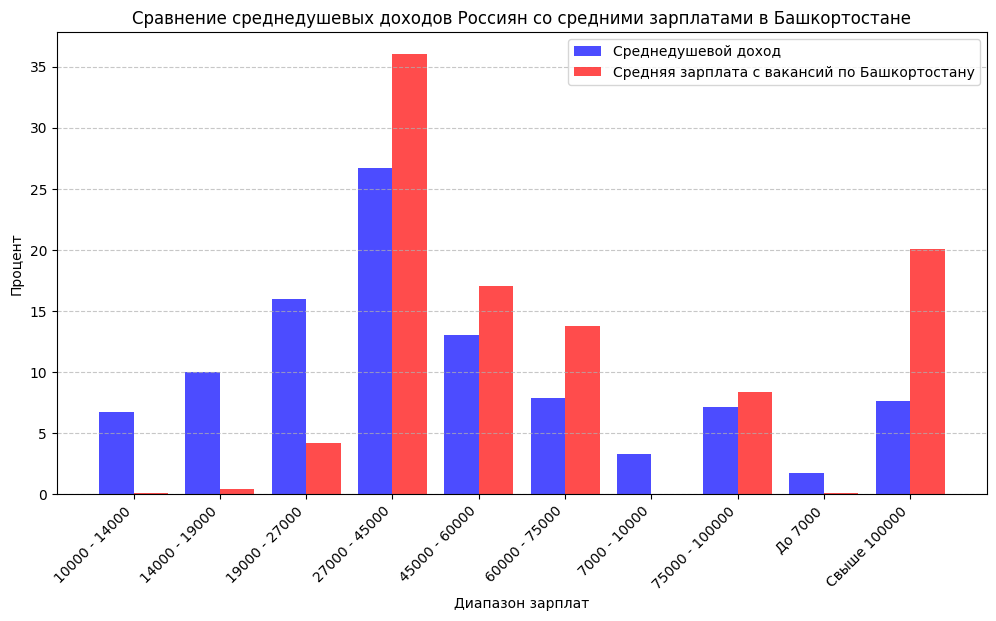

In [ ]:
x = np.arange(len(bash_g['salary_range']))
width = 0.4
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - 0.4/2,bash_g['salary_percentage_rf'], width=0.4 , label="Среднедушевой доход", color="blue", alpha=0.7)
ax.bar(x + 0.4/2, bash_g['percentage_bash'], width=0.4 , label="Средняя зарплата с вакансий по Башкортостану", color="red", alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(bash_g['salary_range'], rotation=45, ha="right")
ax.set_xlabel("Диапазон зарплат")
ax.set_ylabel("Процент")
ax.set_title("Сравнение среднедушевых доходов Россиян со средними зарплатами в Башкортостане")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**1) Вакансий "свыше 100000" сильно больше чем процент людей по России, находящийся в этой группе**

**2) Видно большой процент вакансий в группе "27000-45000"**

**Был добавлен столбец процента вакансий по Уфе (по предложенной зарплате), которые попадают в группы среднедушевого дохода Россиян - percentage_bash**

In [ ]:
basck_g = basck_ufa_only.groupby(['salary_range', 'salary_percentage_rf']).agg({'salary':'count'}).reset_index()
basck_g["percentage_bash"] = (basck_g['salary'] / len(basck_ufa_only))*100
basck_g = basck_g[["salary_range","salary_percentage_rf","percentage_bash"]]
basck_g

,salary_range,salary_percentage_rf,percentage_bash
0,10000 - 14000,6.70,0.23
1,14000 - 19000,10.00,0.68
2,19000 - 27000,16.00,3.86
3,27000 - 45000,26.70,23.64
4,45000 - 60000,13.00,23.64
5,60000 - 75000,7.90,15.45
6,75000 - 100000,7.10,17.27
7,Свыше 100000,7.60,15.23


**Был построен график сравнения процентов людей по России, входящих в группы по доходу и средней зарплаты по вакансиям в Уфе**

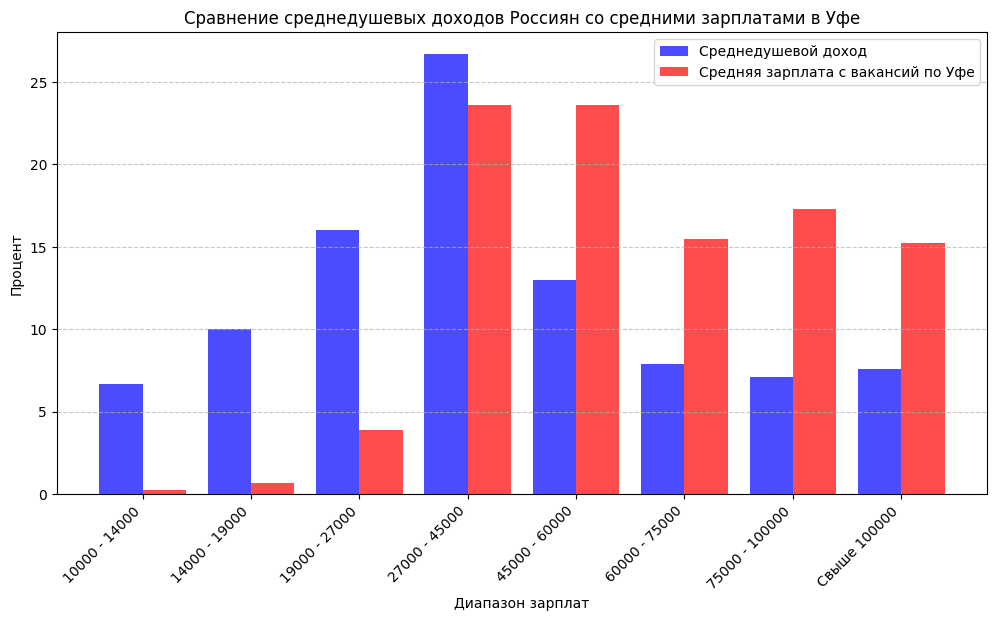

In [ ]:
x = np.arange(len(basck_g['salary_range']))
width = 0.4
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - 0.4/2,basck_g['salary_percentage_rf'], width=0.4 , label="Среднедушевой доход", color="blue", alpha=0.7)
ax.bar(x + 0.4/2, basck_g['percentage_bash'], width=0.4 , label="Средняя зарплата с вакансий по Уфе", color="red", alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(basck_g['salary_range'], rotation=45, ha="right")
ax.set_xlabel("Диапазон зарплат")
ax.set_ylabel("Процент")
ax.set_title("Сравнение среднедушевых доходов Россиян со средними зарплатами в Уфе")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Видно, что вакансии в Уфе в основном находятся в группах 27+, вакансий с зарплатой меньше 27 почти нет**

**Был добавлен столбец процента вакансий по Челябинской области (по предложенной зарплате), которые попадают в группы среднедушевого дохода Россиян - percentage_bash**

In [ ]:
chelyb_g = chelyb.groupby(['salary_range', 'salary_percentage_rf']).agg({'salary':'count'}).reset_index()
chelyb_g["percentage_bash"] = (chelyb_g['salary'] / len(chelyb))*100
chelyb_g= chelyb_g[["salary_range","salary_percentage_rf","percentage_bash"]]
chelyb_g

,salary_range,salary_percentage_rf,percentage_bash
0,10000 - 14000,6.70,0.60
1,14000 - 19000,10.00,0.75
2,19000 - 27000,16.00,3.92
3,27000 - 45000,26.70,27.33
4,45000 - 60000,13.00,19.35
5,60000 - 75000,7.90,12.88
6,7000 - 10000,3.30,0.08
7,75000 - 100000,7.10,14.83
8,Свыше 100000,7.60,20.26


**Был построен график сравнения процентов людей по России, входящих в группы по доходу и средней зарплаты по вакансиям в Челябинской области**

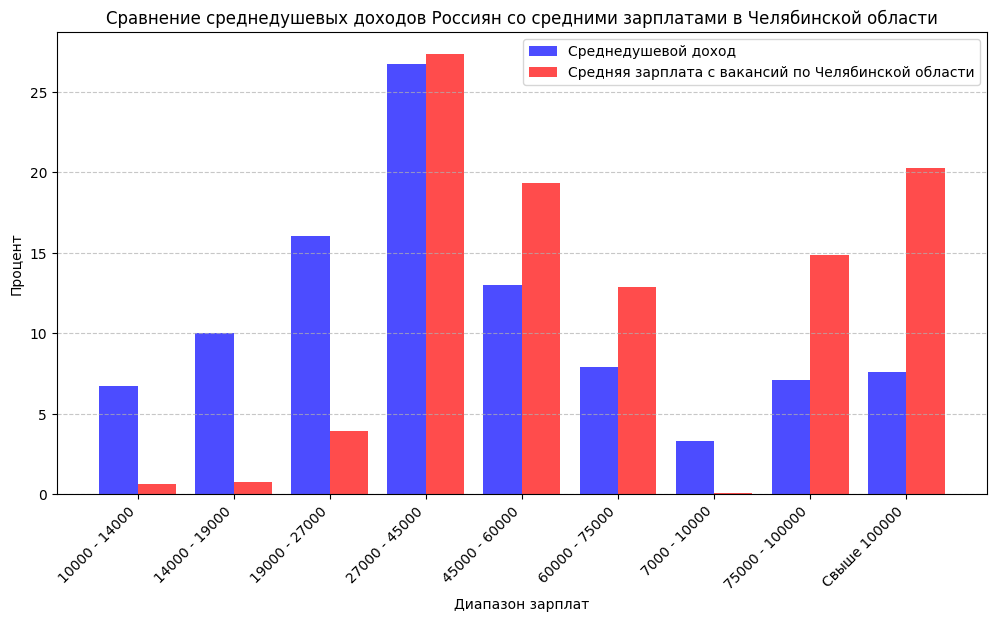

In [ ]:
x = np.arange(len(chelyb_g['salary_range']))
width = 0.4
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - 0.4/2,chelyb_g['salary_percentage_rf'], width=0.4 , label="Среднедушевой доход", color="blue", alpha=0.7)
ax.bar(x + 0.4/2, chelyb_g['percentage_bash'], width=0.4 , label="Средняя зарплата с вакансий по Челябинской области", color="red", alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(chelyb_g['salary_range'], rotation=45, ha="right")
ax.set_xlabel("Диапазон зарплат")
ax.set_ylabel("Процент")
ax.set_title("Сравнение среднедушевых доходов Россиян со средними зарплатами в Челябинской области")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Ситуация по Челябинску похожа на Уфу по распределнию групп зарплат**


# **ЭТАП 5 - Итоговые выводы**

**1) Челябинская область и Башкирия по распределению лучше чем в России в целом**

**2) Челябинская область по среднем зарплате обгоняет Башкирию**

**3) В Башкирии средняя и медианная зарплата при условии опыта работа "более 6 лет" ниже чем при условии опыта работы "от 3 до 6 лет". Это может происходить из-за того, что вакансии в данных момент с условием опыта более 6 лет представлены по низкооплачеваемым спецаильностям, что занижает среднюю зарплату(так как вакансий с такой специальностью немного)**

**4) Самые популярные вакансии по всем рассматриваемым регионам - это менеджер по продажам и продавец-консультант**

**5) Средние зарплаты по вакансиям рассматриваемых регионов сильно ниже
средней зарплаты региона в целом, что свидетельствует об отсутствии большого количества высокооплачиваемых вакансий на сайтах для поиска работы**


